(50000, 785) (50000, 1) (10000, 785) (10000, 1) (10000, 785) (10000, 1)
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
At epoch 43 accuracy:  0.916 test: 0.92 train: 0.916


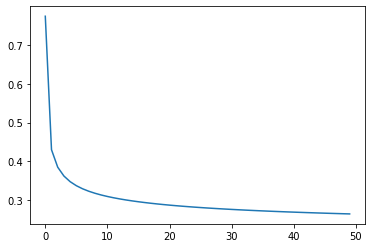

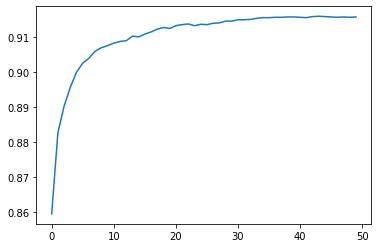

In [159]:
# -*- coding: utf-8 -*-
import numpy as np
import struct
import matplotlib.pyplot as plt
from scipy.special import expit

def readMNISTdata():

    with open('t10k-images-idx3-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        test_data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        test_data = test_data.reshape((size, nrows*ncols))
    
    with open('t10k-labels-idx1-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        test_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        test_labels = test_labels.reshape((size,1))
    
    with open('train-images-idx3-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        train_data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        train_data = train_data.reshape((size, nrows*ncols))
    
    with open('train-labels-idx1-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        train_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        train_labels = train_labels.reshape((size,1))

    # augmenting a constant feature of 1 (absorbing the bias term)
    train_data = np.concatenate( ( np.ones([train_data.shape[0],1]), train_data ), axis=1)
    test_data  = np.concatenate( ( np.ones([test_data.shape[0],1]),  test_data ), axis=1)
    np.random.seed(314)
    np.random.shuffle(train_labels)
    np.random.seed(314)
    np.random.shuffle(train_data)

    X_train = train_data[:50000] / 256
    t_train = train_labels[:50000]

    X_val   = train_data[50000:] /256
    t_val   = train_labels[50000:]

    return X_train, t_train, X_val, t_val, test_data, test_labels


def predict(X, w):
    # X_new: Nsample x (d+1)
    # W: (d+1) x K
    # Predicting
    z = np.dot(X, w)
    # print("z", z)
    y_hat = softmax(z)
    # print(y_hat)
    return np.argmax(y_hat, axis=1)

def calc_loss(y_hat, y, w, decay):
    m = y.shape[0]
    y = y.flatten()
    loss =  np.mean(- np.log(y_hat[np.arange(m), y]))
    decayed = (decay/(2 * m)) * np.power(np.linalg.norm(w, 2), 2)
    return loss + decayed


def one_hot(y, c):
#     print("y ", y)
    y_hot = np.zeros((len(y), c))
    for i in range(len(y)):
#         print(y[i])
        y_hot[i, y[i][0]] = 1

    return y_hot
    

def calc_gradient_w(X, y_hat, y):
#     print(y_hat.shape, y.shape, "y hat", y_hat, "y", y)
    grad = np.dot(X.T, (y_hat - y)) 
    return grad

        
def get_accuracy(y_hat, y):
    y_hat = y_hat.reshape(y.shape[0], 1)
    return np.sum(y==y_hat)/y.shape[0]

def softmax(z):
    exp_max = np.exp(z - np.max(z,axis=-1,keepdims=True))
    out = exp_max/np.sum(exp_max,axis=-1,keepdims=True)
    return out

def train(X_train, y_train, X_val, t_val, N_class, epochs, learning_rate, batch_size, decay):
    N_train = X_train.shape[0]
    N_val   = X_val.shape[0]
    num_features = X_train.shape[1]
    
    # Initializing weights and bias randomly.
    np.random.seed(0)
    w = np.random.rand(num_features, N_class)
    w_best = w
    # Empty list to store losses.
    losses_train = []
    risks_val = []
    risk_best = float("-inf")
    num_batches = int(np.ceil(N_train / batch_size))
    for epoch in range(epochs):
        loss_this_epoch = 0
        print(f"epoch: {epoch}")
        for b in range(num_batches):

            X_batch = X_train[b * batch_size : (b + 1) * batch_size]
            y_batch = y_train[b * batch_size : (b + 1) * batch_size]
            # Calculating hypothesis/prediction.
            z = np.dot(X_batch, w)
            y_hat = softmax(z)
            # One-hot encoding y.
            y_hot = one_hot(y_batch, N_class)
            
            # calc loss 
            loss_this_epoch += calc_loss(y_hat, y_batch, w, decay)
        
            # Calculating the gradient of loss w.r.t w and b.
            w_grad = (1/batch_size) * calc_gradient_w(X_batch, y_hat, y_hot) 
            # Updating the parameters.
            w = w - learning_rate * (w_grad + decay * w)
        
        
        
        # 1. Compute the training loss by averaging loss_this_epoch
        avg_training_loss = loss_this_epoch / num_batches

        # 2. Perform validation on the validation test by the risk
        y_hat_validation = predict(X_val, w)
        # denormalize y_hat and y_test to calculate risks
        validation_risk = get_accuracy(
                y_hat_validation, t_val
        )
        
        risks_val.append(validation_risk)
        losses_train.append(avg_training_loss)
        if validation_risk > risk_best:
            risk_best = validation_risk
            epoch_best = epoch
            w_best = w
 

    return epoch_best, risk_best,  w_best, losses_train, risks_val





##############################
#Main code starts here
X_train, t_train, X_val, t_val, X_test, t_test = readMNISTdata()


print(X_train.shape, t_train.shape, X_val.shape, t_val.shape, X_test.shape, t_test.shape)


N_class = 10
alpha   = 0.1      # learning rate
batch_size   = 100    # batch size
MaxIter = 50        # Maximum iteration
decay = 0.          # weight decay


epoch_best, risk_best, w_best, losses_train, risks_val = train(X_train, t_train, X_val, t_val, N_class, MaxIter, alpha, batch_size, decay)
t_hat_test = predict(X_test, w_best)
acc_test = get_accuracy(t_hat_test, t_test)

plt.figure()
plt.plot(losses_train)
plt.figure()
plt.plot(risks_val)

print('At epoch', epoch_best, 'accuracy: ', risk_best, 'test:', acc_test, 'train:', risk_best)
